## BERTopic anal

# Enable GPU


# **Installing BERTopic**



In [ ]:
%%capture
!pip install bertopic
!pip install openai

## Restarting the Notebook
After installing BERTopic, restart the session.
Runtime → Restart Session

# Load data from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

pubs_path = '/content/drive/My Drive/THESIS/PUBS/' # path to publications
model_path = '/content/drive/My Drive/THESIS/PUBS/savemod/' # path to models


#file_path = pubs_path + 'scopus_pubs.csv' # loads publications from Scopus
file_path = pubs_path + 'wos_pubs.csv' # pubs from WoS
dataset = pd.read_csv(file_path)

# Extract abstracts to train on and corresponding titles and years
abstracts = dataset["abstract"]
titles = dataset["title"]
years = dataset["year"]

dataset.head(10)

Mounted at /content/drive


title  \
0  'Immunogenetics of Aging': report on the activ...   
1  High Concordance of CT Colonography and Colono...   
2  Synthesis, Antitumor and Antibacterial Studies...   
3  Aerobic Microbiological Spectrum and Antibioti...   
4  Synthesis and Biological Studies of New Tempor...   
5  Developing an Intelligent Data Analysis Approa...   
6  Identification of Specific IgE Antibodies and ...   
7  Allergen-Specific IgE and IgG4 as Biomarkers f...   
8  Genetic Basis of Dual Diagnosis: A Review of G...   
9  Abdominal and Thoracic Imaging Features in Chi...   

                                            abstract  year  
0  'Immunogenetics of Aging' is a component that ...  2011  
1  (1) Although new imaging methods for examining...  2023  
2  (1) Background: (KLAKLAK)(2) is a representati...  2021  
3  (1) Background: Anorectal abscesses are a rela...  2024  
4  (1) Background: Antimicrobial resistance is gr...  2024  
5  (1) Background: As the chemical and physicoche...  2022  
6  (1) Background: Asthma is a complex heterogene...  2020  
7  (1) Background: Biomarkers of efficacy for sub...  2021  
8  (1) Background: Comorbidity between Alcohol Us...  2021  
9  (1) Background: Currently, multisystem inflamm...  2022

In [ ]:
len(dataset) # number of entries

11109

# Remove abstract structure words, copyrights, funding, etc.

In [ ]:
import re

# Apply the substitutions using simple replace for clarity and safety
def clean_abstract(text):
    if not isinstance(text, str):
        return text

    # Remove known headers with : or . in UPPERCASE or Title Case
    for header in [
        "BACKGROUND", "OBJECTIVES", "OBJECTIVE", "METHODS", "MATERIALS AND METHODS","Materials and Methods",
        "MATERIALS AND METHODS", "RESULTS", "RESULT", "CONCLUSIONS", "CONCLUSION", "PURPOSE", "AIM", "AIMS",
        "INTRODUCTION", "ABSTRACT", "CONTEXT"
    ]:
        for variant in [header, header.title()]:
            text = text.replace(f"{variant}:", "").replace(f"{variant}.", "").replace(f"{variant} ", "") # also with space after

    # Remove copyright symbol and everything after it
    if "©" in text:
        text = text.split("©")[0]
    if "(C)" in text:
        text = text.split("(C)")[0] # also removes (C) version

    # Remove Funding: and everything after it
    for keyword in ["Funding:", "Funding", "Copyright", "Copyright:" ]:
        if keyword in text:
            text = text.split(keyword)[0]

    return text.strip()

# Apply the function to the DataFrame
dataset['abstract'] = dataset['abstract'].apply(clean_abstract)
abstracts = dataset["abstract"]
dataset.head(10)

title  \
0  'Immunogenetics of Aging': report on the activ...   
1  High Concordance of CT Colonography and Colono...   
2  Synthesis, Antitumor and Antibacterial Studies...   
3  Aerobic Microbiological Spectrum and Antibioti...   
4  Synthesis and Biological Studies of New Tempor...   
5  Developing an Intelligent Data Analysis Approa...   
6  Identification of Specific IgE Antibodies and ...   
7  Allergen-Specific IgE and IgG4 as Biomarkers f...   
8  Genetic Basis of Dual Diagnosis: A Review of G...   
9  Abdominal and Thoracic Imaging Features in Chi...   

                                            abstract  year  
0  'Immunogenetics of Aging' is a component that ...  2011  
1  (1) Although new imaging methods for examining...  2023  
2  (1)  (KLAKLAK)(2) is a representative of the a...  2021  
3  (1)  Anorectal abscesses are a relatively rare...  2024  
4  (1)  Antimicrobial resistance is growing at an...  2024  
5  (1)  As the chemical and physicochemical prope...  2022  
6  (1)  Asthma is a complex heterogeneous disease...  2020  
7  (1)  Biomarkers of efficacy for subcutaneous i...  2021  
8  (1)  Comorbidity between Alcohol Use Disorders...  2021  
9  (1)  Currently, multisystem inflammatory syndr...  2022

In [ ]:
abstracts[14] # prints an abstract [number]

'(1)  Peptides are good candidates for anticancer drugs due to their natural existence in the body and lack of secondary effects. (KLAKLAK)(2) is an antimicrobial peptide that also shows good anticancer properties. (2)  The Solid Phase Peptide Synthesis (Fmoc-strategy) was used for the synthesis of target molecules, analogs of (KLAKLAK)(2)-NH2. The purity of all compounds was monitored by HPLC, and their structures were proven using mass spectrometry. Cytotoxicity and antiproliferative effects were studied using 3T3 NRU and MTT tests, respectively. For determination of antimicrobial activity, the disc-diffusion method was used. Hydrolytic stability at three pH values, which mimic the physiological pH in the body, was investigated by means of the HPLC technique. (3)  A good selective index against MCF-7 tumor cell lines, combined with good cytotoxicity and antiproliferative properties, was revealed for conjugates NphtG-(KLAKLAK)(2)-NH2 and Caf-(KLAKLAK)(2)-NH2. The same compounds showed

# **Best Practices**



## **Pre-calculate Embeddings**
After having created our data, namely `abstracts`, we can  **pre-calculating embeddings**.

BERTopic works by converting documents into numerical values, called embeddings.

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/348 [00:00<?, ?it/s]

## **Dimensionality Reduction**

This is done with [UMAP](https://github.com/lmcinnes/umap) which is an incredible algorithm for reducing dimensional space. However, by default, it shows stochastic behavior which creates different results each time you run it. To prevent that, we will need to set a `random_state` of the model before passing it to BERTopic.

As a result, we can now fully reproduce the results each time we run the model.

In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## **HDBSCAN clustering**

Topics number control

Here, we go with `min_cluster_size=30` to get around 100 topics.

In [ ]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True) #

## **Improving Default Representation**
The default representation of topics is calculated through [c-TF-IDF](https://maartengr.github.io/BERTopic/algorithm/algorithm.html#5-topic-representation). However, c-TF-IDF is powered by the [CountVectorizer](https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html) which converts text into tokens. Using the CountVectorizer, we can do a number of things:

* Remove stopwords
* Ignore infrequent words
* Increase

In other words, we can preprocess the topic representations **after** documents are assigned to topics. This will not influence the clustering process in any way.

Here, we will ignore English stopwords and infrequent words. Moreover, by increasing the n-gram range we will consider topic representations that are made up of one or two words.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## **Additional Representations**
Previously, we have tuned the default representation but there are quite a number of [other topic representations](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html) in BERTopic that we can choose from. From [KeyBERTInspired](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired) and [PartOfSpeech](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#partofspeech), to [OpenAI's ChatGPT](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#chatgpt) and [open-source](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#langchain) alternatives, many representations are possible.

In BERTopic, you can model many different topic representations simultanously to test them out and get different perspectives of topic descriptions. This is called [multi-aspect](https://maartengr.github.io/BERTopic/getting_started/multiaspect/multiaspect.html) topic modeling.

Here, we will demonstrate a number of interesting and useful representations in BERTopic:

* KeyBERTInspired
  * A method that derives inspiration from how KeyBERT works
* PartOfSpeech
  * Using SpaCy's POS tagging to extract words
* MaximalMarginalRelevance
  * Diversify the topic words
* OpenAI
  * Use ChatGPT to label our topics


In [ ]:
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key="YOUR OPEN AI API KEY")
openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
  # "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    "POS": pos_model
}

## **Training**
Now that we have a set of best practices, we can use them in our training loop. Here, several different representations, keywords and labels for our topics will be created. If you want to iterate over the topic model it is advised to use the pre-calculated embeddings as that significantly speeds up training.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  calculate_probabilities=True # a bit slow
)

topics, probs = topic_model.fit_transform(abstracts, embeddings)

2025-05-20 12:20:40,117 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 12:21:14,823 - BERTopic - Dimensionality - Completed ✓
2025-05-20 12:21:14,824 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 12:21:19,513 - BERTopic - Cluster - Completed ✓
2025-05-20 12:21:19,521 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 84/84 [00:43<00:00,  1.93it/s]
2025-05-20 12:23:04,764 - BERTopic - Representation - Completed ✓


In [ ]:
#scopus_model = topic_model
wos_model = topic_model

In [ ]:
topic_model.get_topic_info() # show topic info

Topic  Count                                           Name  \
0      -1   4112                 -1_patients_study_data_results   
1       0    623                0_dental_teeth_periodontal_oral   
2       1    312        1_extracts_antioxidant_extract_phenolic   
3       2    282                       2_covid_covid 19_19_sars   
4       3    234     3_isolates_resistance_resistant_antibiotic   
..    ...    ...                                            ...   
79     78     32                          78_il_crc_tumor_cells   
80     79     31           79_noise_traffic_greenspace_exposure   
81     80     30               80_nerve_muscle_variations_ulnar   
82     81     30  81_dental_sensitization_students_formaldehyde   
83     82     30                      82_ache_compounds_mao_gal   

                                       Representation  \
0   [patients, study, data, results, used, cells, ...   
1   [dental, teeth, periodontal, oral, root, treat...   
2   [extracts, antioxidant, extract, phenolic, com...   
3   [covid, covid 19, 19, sars, cov, sars cov, vac...   
4   [isolates, resistance, resistant, antibiotic, ...   
..                                                ...   
79  [il, crc, tumor, cells, tgf, cancer, crc patie...   
80  [noise, traffic, greenspace, exposure, road, d...   
81  [nerve, muscle, variations, ulnar, skull, fora...   
82  [dental, sensitization, students, formaldehyde...   
83  [ache, compounds, mao, gal, sh sy5y, sy5y, ofq...   

                                              KeyBERT  \
0   [health, diabetes, patients, serum, disorders,...   
1   [root canal, endodontic, dentistry, periodonta...   
2   [antioxidant activity, antioxidant, phytochemi...   
3   [covid 19, coronavirus disease, 19 vaccination...   
4   [antibiotic resistance, antimicrobial resistan...   
..                                                ...   
79  [cytokines, colorectal cancer, immune checkpoi...   
80  [noise exposure, occupational noise, noise ann...   
81  [musculocutaneous nerve, radial nerve, median ...   
82  [students dental, dental materials, dental med...   
83  [neuroprotective antioxidant, monoamine oxidas...   

                                        OpenAI  \
0               [Health Risk Factors Analysis]   
1              [Dental Laser Root Canal Study]   
2    [Phenolic and Antioxidant Plant Extracts]   
3          [COVID-19 vaccination and outcomes]   
4          [Antibiotic Resistance in Bulgaria]   
..                                         ...   
79              [Local IL-2 therapy in cancer]   
80            [Noise and Environmental Health]   
81               [Nerve and muscle variations]   
82                [Dental Sensitization Study]   
83  [Multi-targeted Neuroprotective Compounds]   

                                                  MMR  \
0   [data, cells, clinical, levels, activity, risk...   
1   [dental, teeth, periodontal, oral, periodontit...   
2   [extracts, antioxidant, phenolic, mg, flavonoi...   
3   [covid, covid 19, sars cov, pandemic, vaccines...   
4   [resistant, infections, antimicrobial, strains...   
..                                                ...   
79  [crc patients, immune, tgf beta, cd68, colorec...   
80  [road traffic, occupational noise, pollution, ...   
81  [nerve, foramen, nerves, innervation, fossa, u...   
82  [sensitization, formaldehyde, students dental,...   
83  [ache, compounds, mao, neuroprotective, rat br...   

                                                  POS  \
0   [patients, study, data, results, cells, treatm...   
1   [dental, teeth, periodontal, oral, root, treat...   
2   [extracts, antioxidant, extract, phenolic, com...   
3   [vaccination, coronavirus, vaccine, infection,...   
4   [isolates, resistance, resistant, antibiotic, ...   
..                                                ...   
79  [tumor, cells, cancer, immune, expression, col...   
80  [noise, traffic, greenspace, exposure, road, u...   
81  [nerve, muscle, variations

To get all representations for a single topic, we simply run the following:

In [ ]:
topic_model.get_topic(3, full=True) # get info on specific topic

{'Main': [('isolates', np.float64(0.031176666146424892)),
  ('resistance', np.float64(0.022960755378513654)),
  ('resistant', np.float64(0.018061942139149845)),
  ('antibiotic', np.float64(0.015465671740287353)),
  ('infections', np.float64(0.015110560217705432)),
  ('antimicrobial', np.float64(0.013839029677535331)),
  ('strains', np.float64(0.01325788873133842)),
  ('pneumoniae', np.float64(0.012090035053877195)),
  ('infection', np.float64(0.01054632180607101)),
  ('genes', np.float64(0.009221167365542269))],
 'KeyBERT': [('antibiotic resistance', np.float32(0.5846723)),
  ('antimicrobial resistance', np.float32(0.58171755)),
  ('pathogens', np.float32(0.4925661)),
  ('antimicrobial susceptibility', np.float32(0.4910775)),
  ('pathogen', np.float32(0.47132966)),
  ('antibiotics', np.float32(0.44828096)),
  ('streptococcus', np.float32(0.4463857)),
  ('antimicrobial', np.float32(0.44397473)),
  ('lactamase', np.float32(0.43359143)),
  ('bacterial', np.float32(0.4190662))],
 'OpenAI':

**NOTE**: The labels generated by OpenAI's **ChatGPT** are especially interesting to use throughout your model. Below, we will go into more detail how to set that as a custom label.

## **(Custom) Labels**
The default label of each topic are the top 3 words in each topic combined with an underscore between them.

This, of course, might not be the best label that you can think of for a certain topic. Instead, we can use `.set_topic_labels` to manually label all or certain topics.

We can also use `.set_topic_labels` to use one of the other topic representations that we had before, like `KeyBERTInspired` or even `OpenAI`.

In [ ]:
# Label the topics yourself
#topic_model.set_topic_labels({1: "Space Travel", 7: "Religion"})

# or use one of the other topic representations, like KeyBERTInspired
#keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for #topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
#topic_model.set_topic_labels(keybert_topic_labels)

# or ChatGPT's labels
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

Now that we have set the updated topic labels, we can access them with the many functions used throughout BERTopic. Most notably, you can show the updated labels in visualizations with the `custom_labels=True` parameters.

In [ ]:
topic_model.get_topic_info() # get topics info with LLM labels

Topic  Count                                           Name  \
0      -1   4112                 -1_patients_study_data_results   
1       0    623                0_dental_teeth_periodontal_oral   
2       1    312        1_extracts_antioxidant_extract_phenolic   
3       2    282                       2_covid_covid 19_19_sars   
4       3    234     3_isolates_resistance_resistant_antibiotic   
..    ...    ...                                            ...   
79     78     32                          78_il_crc_tumor_cells   
80     79     31           79_noise_traffic_greenspace_exposure   
81     80     30               80_nerve_muscle_variations_ulnar   
82     81     30  81_dental_sensitization_students_formaldehyde   
83     82     30                      82_ache_compounds_mao_gal   

                                         CustomName  \
0                                     Outlier Topic   
1                     Dental Laser Root Canal Study   
2      Medicinal plant extracts antioxidant profile   
3         COVID-19 vaccination efficacy and safety.   
4   Antimicrobial Resistance in Bulgarian Hospitals   
..                                              ...   
79                      Therapeutic effects of IL-2   
80                   Noise and Environmental Health   
81                      Nerve and Muscle Variations   
82                     Dental Sensitization Studies   
83         Multifunctional Neuroprotective Compound   

                                       Representation  \
0   [patients, study, data, results, used, cells, ...   
1   [dental, teeth, periodontal, oral, root, treat...   
2   [extracts, antioxidant, extract, phenolic, com...   
3   [covid, covid 19, 19, sars, cov, sars cov, vac...   
4   [isolates, resistance, resistant, antibiotic, ...   
..                                                ...   
79  [il, crc, tumor, cells, tgf, cancer, crc patie...   
80  [noise, traffic, greenspace, exposure, road, d...   
81  [nerve, muscle, variations, ulnar, skull, fora...   
82  [dental, sensitization, students, formaldehyde...   
83  [ache, compounds, mao, gal, sh sy5y, sy5y, ofq...   

                                              KeyBERT  \
0   [health, diabetes, patients, serum, disorders,...   
1   [root canal, endodontic, dentistry, periodonta...   
2   [antioxidant activity, antioxidant, phytochemi...   
3   [covid 19, coronavirus disease, 19 vaccination...   
4   [antibiotic resistance, antimicrobial resistan...   
..                                                ...   
79  [cytokines, colorectal cancer, immune checkpoi...   
80  [noise exposure, occupational noise, noise ann...   
81  [musculocutaneous nerve, radial nerve, median ...   
82  [students dental, dental materials, dental med...   
83  [neuroprotective antioxidant, monoamine oxidas...   

                                               OpenAI  \
0               [GHD and cardiovascular risk factors]   
1                     [Dental Laser Root Canal Study]   
2      [Medicinal plant extracts antioxidant profile]   
3         [COVID-19 vaccination efficacy and safety.]   
4   [Antimicrobial Resistance in Bulgarian Hospitals]   
..                                                ...   
79                      [Therapeutic effects of IL-2]   
80                   [Noise and Environmental Health]   
81                      [Nerve and Muscle Variations]   
82                     [Dental Sensitization Studies]   
83         [Multifunctional Neuroprotective Compound]   

                                                  MMR  \
0   [data, cells, clinical, levels, activity, risk...   
1   [dental, teeth, periodontal, oral, periodontit...   
2   [extracts, antioxidant, phenolic, mg, flavonoi...   
3   [covid, covid 19, sars cov, pandemic, vaccines...   
4   [resistant, infections, antimicrobial, strains...   
..                                                ...   
79  [crc patients, immune, tgf beta, cd68, colorec...   
80  [road traffic, occupati

Notice that the overview in `.get_topic_info` now also includes the column `CustomName`. That is the custom label that we just created for each topic.

## **Visualize Topics**

With visualizations, we are closing into the realm of subjective "best practices". These are things that I generally do because I like the representations but your experience might differ.

Having said that, there are two visualizations that are my go-to when visualizing the topics themselves:

* `topic_model.visualize_topics()`
* `topic_model.visualize_hierarchy()`

In [ ]:
topic_model.visualize_topics(custom_labels=True)

In [ ]:
from bertopic import BERTopic

hierarchical_topics = topic_model.hierarchical_topics(abstracts)

topic_model.visualize_hierarchy(custom_labels=True, hierarchical_topics=hierarchical_topics)

100%|██████████| 78/78 [00:00<00:00, 101.19it/s]


## Topics over time

In [ ]:
topics_over_time = topic_model.topics_over_time(abstracts, years)
selected_topics = list(range(1, 10)) # here choose topics to visualise
topic_model.visualize_topics_over_time(topics_over_time, topics=selected_topics, custom_labels=True)

26it [00:35,  1.37s/it]


## **WORDCLOUDS**"

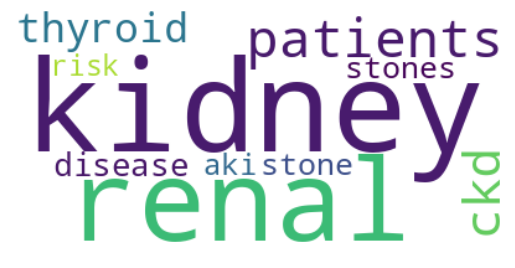

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=6)

## **Vizualise terms of top 10 topics**

In [ ]:
#topic_model.visualize_barchart()
topic_model.visualize_barchart(top_n_topics=10, n_words=10, custom_labels=True)

## **Visualize Documents**

When visualizing documents, it helps to have embedded the documents beforehand to speed up computation. Fortunately, we have already done that as a "best practice".

Visualizing documents in 2-dimensional space helps in understanding the underlying structure of the documents and topics.

In [ ]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

The following plot is **interactive** which means that you can zoom in, double click on a label to only see that one and generally interact with the plot:

In [ ]:
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, custom_labels=True)

In [ ]:
# We can also hide the annotation to have a more clear overview of the topics
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

**💡  NOTE - 2-dimensional space 💡**
***
Although visualizing the documents in 2-dimensional gives an idea of their underlying structure, there is a risk involved.

Visualizing the documents in 2-dimensional space means that we have lost significant information since the original embeddings were more than 384 dimensions. Condensing all that information in 2 dimensions is simply not possible. In other words, it is merely an **approximation**, albeit quite an accurate one.
***

In [ ]:
loaded_model.visualize_hierarchy(custom_labels=True, hierarchical_topics=hierarchical_topics)

## **SAVE topic info into files for analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from bertopic import BERTopic # Ensure BERTopic is imported here if it's not guaranteed by the notebook structure
from google.colab import files # Ensure files is imported here

# Save directly to root directory for better visibility
output_dir = "/content"
print(f"Will save files to: {output_dir}")

def extract_model_data(model, dataset_name, abstracts, years, titles):
    """Extract all necessary data from a fitted BERTopic model"""
    print(f"Starting extraction for {dataset_name} dataset...")

    # Check if the model has a custom_labels_ attribute and if it's a dictionary
    has_custom_labels = hasattr(model, 'custom_labels_') and isinstance(model.custom_labels_, dict)
    print(f"Model has valid custom labels dictionary: {has_custom_labels}") # Added for debugging

    # 1. Basic Topic Information
    print("Extracting topic info...")
    # get_topic_info already includes 'CustomName' if custom_labels_ is set correctly on the model object
    topic_info = model.get_topic_info()

    # Save file
    output_file = f"{output_dir}/{dataset_name}_topics.csv"
    # If 'CustomName' is in topic_info, it will be saved automatically
    topic_info.to_csv(output_file, index=False)
    print(f"File saved: {output_file}")

    # 2. Topic keywords - simplified format
    print("Extracting topic keywords...")
    keywords_data = []

    for topic in topic_info.Topic:
        if topic != -1:  # Skip outlier topic
            words = model.get_topic(topic)
            # Safely get custom label
            custom_label = model.custom_labels_.get(topic, f"Topic {topic}") if has_custom_labels else f"Topic {topic}"

            for word, score in words:
                keywords_data.append({
                    'topic': topic,
                    'word': word,
                    'score': score,
                    'custom_label': custom_label # Use the safely retrieved label
                })

    keywords_df = pd.DataFrame(keywords_data)
    output_file = f"{output_dir}/{dataset_name}_keywords.csv"
    keywords_df.to_csv(output_file, index=False)
    print(f"File saved: {output_file}")

    # 3. Document-Topic assignments
    print("Extracting document topics...")
    doc_topics = []
    # Use the fitted model to get topics and probabilities for documents
    # Assuming abstracts, years, titles are aligned
    # Check if abstracts is a pandas Series and convert to list if needed for zip
    if isinstance(abstracts, pd.Series):
        abstracts_list = abstracts.tolist()
    else:
        abstracts_list = abstracts # Assume it's already list or compatible

    # Check if years is a pandas Series and convert to list if needed for zip
    if isinstance(years, pd.Series):
        years_list = years.tolist()
    else:
        years_list = years # Assume it's already list or compatible

     # Check if titles is a pandas Series and convert to list if needed for zip
    if isinstance(titles, pd.Series):
        titles_list = titles.tolist()
    else:
        titles_list = titles # Assume it's already list or compatible


    topics, probs = model.transform(abstracts_list) # Pass the list version

    for i, (topic, prob_array) in enumerate(zip(topics, probs)):
        # Probabilities returned by transform are for ALL topics, need to find prob for assigned topic
        # Find the index of the assigned topic in the list of all topics
        max_prob = 0
        if topic != -1:
             # Get all topics from the model to find the index of the assigned topic
            all_topics_in_model = sorted(model.get_topic_info()['Topic'].tolist())
            try:
                topic_index = all_topics_in_model.index(topic)
                # Ensure prob_array is not empty and index is valid
                if prob_array is not None and len(prob_array) > topic_index:
                     max_prob = prob_array[topic_index]
                else:
                    max_prob = 0 # Fallback if probabilities are not structured as expected
            except ValueError:
                 # Should not happen if topic comes from model.transform
                max_prob = 0
        else:
            max_prob = 0 # Outlier topic has no specific probability distribution from BERTopic transform

        # Safely get custom label for documents
        custom_label = "Outlier" if topic == -1 else (model.custom_labels_.get(topic, f"Topic {topic}") if has_custom_labels else f"Topic {topic}")


        doc_info = {
            'title': titles_list[i] if i < len(titles_list) else f"Document {i}",
            'year': years_list[i] if i < len(years_list) else "Unknown",
            'topic': topic,
            'probability': max_prob,
            'custom_label': custom_label # Use the safely retrieved label
        }
        doc_topics.append(doc_info)

    doc_topic_df = pd.DataFrame(doc_topics)
    output_file = f"{output_dir}/{dataset_name}_document_topics.csv"
    doc_topic_df.to_csv(output_file, index=False)
    print(f"File saved: {output_file}")

    # 4. Topics over time - simplified
    try:
        print("Extracting topics over time...")
        # Create direct year-based counts
        topic_years = {}
        # Ensure topics and years have the same length
        if len(topics) != len(years_list): # Compare with the list version of years
            print("Warning: Length of topics and years do not match. Skipping topics over time extraction.")
        else:
            for i, (topic, year) in enumerate(zip(topics, years_list)): # Iterate over the list version of years
                if topic == -1:  # Skip outliers
                    continue

                # Safely get custom label for time data
                custom_label = model.custom_labels_.get(topic, f"Topic {topic}") if has_custom_labels else f"Topic {topic}"

                year_str = str(year)
                if year_str not in topic_years:
                    topic_years[year_str] = {}

                if topic not in topic_years[year_str]:
                    topic_years[year_str][topic] = {'count': 0, 'custom_label': custom_label} # Store count and label

                topic_years[year_str][topic]['count'] += 1

            # Convert to dataframe
            time_data = []
            for year, topics_dict in topic_years.items():
                for topic, data in topics_dict.items():
                    time_data.append({
                        'Year': year,
                        'Topic': topic,
                        'Count': data['count'],
                        'Custom_Label': data['custom_label'] # Use the stored custom label
                    })

            time_df = pd.DataFrame(time_data)
            output_file = f"{output_dir}/{dataset_name}_topics_time.csv"
            time_df.to_csv(output_file, index=False)
            print(f"File saved: {output_file}")
    except Exception as e:
        print(f"Error generating topics over time: {e}")

    print(f"Completed extraction for {dataset_name}")

# Example usage after fitting your model:
# Ensure you have run the code to fit topic_model and load the data (abstracts, years, titles) first.
# extract_model_data(topic_model, "scopus", abstracts, years, titles)

# Uncomment the correct line below based on which dataset you are processing
# If you loaded wos_pubs.csv, use this line:

extract_model_data(topic_model, "wos", abstracts, years, titles)
#extract_model_data(topic_model, "scopus", abstracts, years, titles)




# File download from Colab
from google.colab import files
print("\nAfter running the extraction, download each CSV file individually:")
print("files.download('scopus_topics.csv')")
print("files.download('scopus_keywords.csv')")
print("files.download('scopus_document_topics.csv')")
print("files.download('scopus_topics_time.csv')")
print("files.download('wos_topics.csv')")
print("files.download('wos_keywords.csv')")
print("files.download('wos_document_topics.csv')")
print("files.download('wos_topics_time.csv')")

Will save files to: /content
Starting extraction for wos dataset...
Model has valid custom labels dictionary: False
Extracting topic info...
File saved: /content/wos_topics.csv
Extracting topic keywords...
File saved: /content/wos_keywords.csv
Extracting document topics...


Batches:   0%|          | 0/348 [00:00<?, ?it/s]

2025-05-20 12:24:15,192 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-20 12:24:15,227 - BERTopic - Dimensionality - Completed ✓
2025-05-20 12:24:15,228 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-20 12:24:15,962 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-20 12:24:20,916 - BERTopic - Probabilities - Completed ✓
2025-05-20 12:24:20,917 - BERTopic - Cluster - Completed ✓


File saved: /content/wos_document_topics.csv
Extracting topics over time...
File saved: /content/wos_topics_time.csv
Completed extraction for wos

After running the extraction, download each CSV file individually:
files.download('scopus_topics.csv')
files.download('scopus_keywords.csv')
files.download('scopus_document_topics.csv')
files.download('scopus_topics_time.csv')
files.download('wos_topics.csv')
files.download('wos_keywords.csv')
files.download('wos_document_topics.csv')
files.download('wos_topics_time.csv')


## **SAVE visualizations**

In [ ]:
# Ensure necessary libraries are imported
from bertopic import BERTopic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files # For downloading files in Colab

# **Install kaleido for image export**
# This line is commented out as we are no longer saving PNGs requiring kaleido.
# If you still need PNGs for other purposes, you might need to troubleshoot kaleido installation/environment.
# !pip install kaleido

# Define output directory
output_dir = "/content"
print(f"Saving visualization files to: {output_dir}")

# Assume 'topic_model' is your fitted BERTopic model
# Assume 'abstracts', 'years', 'titles', 'topic_distr', 'hierarchical_topics', 'reduced_embeddings'
# are already defined from previous cells in the notebook.

# --- Save Key Visualizations as PNGs ---
# These sections are removed as we are no longer using kaleido for PNG export.


# --- Save Interactive HTML Files ---
# HTML files do not require the kaleido engine and should work without it.

# 1. Visualize Intertopic Distance Map (HTML)
print("Saving Intertopic Distance Map as HTML...")
topic_model.visualize_topics(custom_labels=True).write_html(os.path.join(output_dir, "intertopic_distance.html"))
print(f"Saved: {os.path.join(output_dir, 'intertopic_distance.html')}")

# 2. Visualize Barchart (HTML) - Modified to show top 20 topics
print("Saving Topic Barchart (Top 20) as HTML...")
# Increased top_n_topics to 20
topic_model.visualize_barchart(top_n_topics=20, n_words=10, custom_labels=True).write_html(os.path.join(output_dir, "topic_barcharts_top20.html"))
print(f"Saved: {os.path.join(output_dir, 'topic_barcharts_top20.html')}")


# 3. Visualize Hierarchy (HTML)
# Ensure hierarchical_topics is generated if not already
if 'hierarchical_topics' not in locals():
    print("Generating hierarchical topics for visualization...")
    try:
        hierarchical_topics = topic_model.hierarchical_topics(abstracts)
    except Exception as e:
         print(f"Could not generate hierarchical topics: {e}")
         hierarchical_topics = None # Set to None if it fails

if hierarchical_topics is not None:
    print("Saving Hierarchy Plot as HTML...")
    topic_model.visualize_hierarchy(custom_labels=True, hierarchical_topics=hierarchical_topics).write_html(os.path.join(output_dir, "topic_hierarchy.html"))
    print(f"Saved: {os.path.join(output_dir, 'topic_hierarchy.html')}")
else:
    print("Skipping Hierarchy Plot HTML as hierarchical topics could not be generated.")

# 4. Visualize Topics over Time (HTML)
# Ensure topics_over_time is generated if not already
if 'topics_over_time' not in locals():
     print("Generating topics over time for visualization...")
     try:
         # Ensure abstracts and years are available and aligned
         if 'abstracts' in locals() and 'years' in locals() and len(abstracts) == len(years):
             topics_over_time = topic_model.topics_over_time(abstracts, years)
         else:
             print("Abstracts or years missing/misaligned. Cannot generate topics over time.")
             topics_over_time = None
     except Exception as e:
         print(f"Could not generate topics over time: {e}")
         topics_over_time = None


if topics_over_time is not None and not topics_over_time.empty:
    print("Saving Topics over Time Plot as HTML...")
    # For HTML, we can visualize more topics if desired, or stick to the selected ones
    try:
        topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True).write_html(os.path.join(output_dir, "topics_over_time.html"))
        print(f"Saved: {os.path.join(output_dir, 'topics_over_time.html')}")
    except Exception as e:
        print(f"Could not save Topics over Time HTML: {e}")
else:
    print("Skipping Topics over Time Plot HTML as data is missing or empty.")

# 5. Visualize Documents (HTML)
# Requires reduced_embeddings, abstracts (or titles), and topic assignments
# Ensure reduced_embeddings exists. If not, recreate it.
if 'reduced_embeddings' not in locals() or reduced_embeddings is None:
    print("Generating 2D reduced embeddings for document visualization...")
    try:
        from umap import UMAP
        # Use the embedding model used for the BERTopic model
        # Assuming embedding_model is defined from previous cells or loaded model
        if 'embedding_model' in locals():
             # BERTopic.load with save_embedding_model='path' does NOT return the actual model object,
             # it returns a string path. Need to load it again if it's a string.
             if isinstance(embedding_model, str):
                  try:
                       from sentence_transformers import SentenceTransformer
                       embedding_model_obj = SentenceTransformer(embedding_model)
                       # Use the original embeddings generated from this model
                       if 'embeddings' in locals() and embeddings is not None:
                           print("Using existing original embeddings for reduction.")
                           reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
                       else:
                           print("Original embeddings ('embeddings') not found. Cannot generate reduced embeddings for doc viz.")
                           reduced_embeddings = None
                           # You might need to re-encode abstracts if embeddings are not available
                           # embeddings = embedding_model_obj.encode(abstracts, show_progress_bar=True)
                           # reduced_embeddings = UMAP(...).fit_transform(embeddings)

                  except ImportError:
                       print("sentence_transformers not imported. Cannot load embedding model for reduction.")
                       reduced_embeddings = None
                  except Exception as e:
                        print(f"Error loading embedding model or creating reduced embeddings: {e}")
                        reduced_embeddings = None
             else: # Assuming embedding_model is already a SentenceTransformer object
                 if 'embeddings' in locals() and embeddings is not None:
                    print("Using existing original embeddings for reduction.")
                    reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
                 else:
                     print("Original embeddings ('embeddings') not found. Cannot generate reduced embeddings for doc viz.")
                     reduced_embeddings = None
             print("Finished generating 2D reduced embeddings.")
        else:
             print("Embedding model ('embedding_model') not found. Cannot generate reduced embeddings for doc viz.")
             reduced_embeddings = None

    except ImportError:
         print("UMAP not imported. Cannot generate reduced embeddings for doc viz.")
         reduced_embeddings = None
    except Exception as e:
         print(f"Could not generate reduced embeddings: {e}")
         reduced_embeddings = None


# Check if necessary components for document visualization exist
if reduced_embeddings is not None and 'titles' in locals() and titles is not None and 'topics' in locals() and topics is not None:
    print("Saving Documents Plot as HTML...")
    # Ensure titles is a list for the visualization function
    if isinstance(titles, pd.Series):
        titles_list = titles.tolist()
    else:
        titles_list = titles # Assume it's already list or compatible

    try:
        topic_model.visualize_documents(titles_list, reduced_embeddings=reduced_embeddings, custom_labels=True).write_html(os.path.join(output_dir, "documents_scatter.html"))
        print(f"Saved: {os.path.join(output_dir, 'documents_scatter.html')}")
    except Exception as e:
         print(f"Could not save Documents Plot HTML: {e}")
else:
     print("Skipping Documents Plot HTML as required data (reduced embeddings, titles, or topics) is missing.")
# --- Visualize and Save Topic Similarity Heatmap ---
print("Visualizing and saving Topic Similarity Heatmap...")
try:
    # Visualize and save the heatmap as HTML
    output_file_html = os.path.join(output_dir, "topic_similarity_heatmap.html")
    # Use custom_labels=True if you want the heatmap to show custom labels
    topic_model.visualize_heatmap(custom_labels=True).write_html(output_file_html)
    print(f"Saved: {output_file_html}")

except Exception as e:
    # The error message is adjusted to reflect that only the heatmap saving is attempted here
    print(f"Could not visualize or save Topic Similarity Heatmap: {e}")

# Update the list of output files to include the heatmap HTML and remove the CSV
output_files = [
    "intertopic_distance.html",
    "topic_barcharts_top20.html", # Updated filename
    "topic_hierarchy.html", # Will only be available if generated
    "topics_over_time.html", # Will only be available if generated
    "documents_scatter.html", # Will only be available if generated
    "topic_similarity_heatmap.html" # Add the new heatmap HTML
]

print("\nAfter running the visualization and data saving code, download the files:")
for filename in output_files:
    print(f"files.download('{filename}') # Check if this file was successfully created based on the output above")



Saving visualization files to: /content
Saving Intertopic Distance Map as HTML...
Saved: /content/intertopic_distance.html
Saving Topic Barchart (Top 20) as HTML...
Saved: /content/topic_barcharts_top20.html
Generating hierarchical topics for visualization...


100%|██████████| 82/82 [00:01<00:00, 43.28it/s]


Saving Hierarchy Plot as HTML...
Saved: /content/topic_hierarchy.html
Generating topics over time for visualization...


26it [00:39,  1.53s/it]


Saving Topics over Time Plot as HTML...
Saved: /content/topics_over_time.html
Generating 2D reduced embeddings for document visualization...
Using existing original embeddings for reduction.
Finished generating 2D reduced embeddings.
Saving Documents Plot as HTML...
Saved: /content/documents_scatter.html
Visualizing and saving Topic Similarity Heatmap...
Saved: /content/topic_similarity_heatmap.html

After running the visualization and data saving code, download the files:
files.download('intertopic_distance.html') # Check if this file was successfully created based on the output above
files.download('topic_barcharts_top20.html') # Check if this file was successfully created based on the output above
files.download('topic_hierarchy.html') # Check if this file was successfully created based on the output above
files.download('topics_over_time.html') # Check if this file was successfully created based on the output above
files.download('documents_scatter.html') # Check if this file was s

## **SAVE wordclouds**

In [ ]:
# Ensure necessary libraries are imported
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os # Import os for path joining
import pandas as pd # Import pandas to work with topic_info

# Define the number of top topics you want wordclouds for
num_top_topics = 20 # You can change this number

# Define the output directory for wordclouds
wordcloud_output_dir = "/content/wordclouds"
os.makedirs(wordcloud_output_dir, exist_ok=True) # Create the directory if it doesn't exist
print(f"Saving wordclouds to: {wordcloud_output_dir}")

# Refined create_wordcloud function to return figure and avoid immediate show
def create_wordcloud(model, topic_id):
    """Generates a wordcloud for a given topic and returns the matplotlib figure."""
    # Ensure the topic_id is valid and not the outlier topic -1
    if topic_id == -1:
        print(f"Skipping wordcloud for outlier topic (-1).")
        return None

    try:
        text = {word: value for word, value in model.get_topic(topic_id)}
        if not text:
            print(f"No words found for topic {topic_id}. Skipping wordcloud.")
            return None

        wc = WordCloud(background_color="white", max_words=1000)
        wc.generate_from_frequencies(text)

        fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and axes
        ax.imshow(wc, interpolation="bilinear")
        ax.set_axis_off()
        # Add a title to the wordcloud
        topic_info = model.get_topic_info()
        # Find the custom label for the current topic_id, default to "Topic X" if not found or no custom labels
        custom_label = "Topic not found" # Default if topic_id is somehow not in topic_info
        topic_row = topic_info[topic_info['Topic'] == topic_id]
        if not topic_row.empty:
            # Use .iloc[0] to get the first row if there are duplicates (shouldn't be for Topic ID)
            custom_label = topic_row.iloc[0].get('CustomName', f"Topic {topic_id}")
        ax.set_title(f"Wordcloud for {custom_label}", fontsize=14)


        return fig # Return the figure object

    except Exception as e:
        print(f"Error creating wordcloud for topic {topic_id}: {e}")
        return None


# Get topic information to identify top topics (excluding the outlier topic -1)
# Sort by 'Count' in descending order and select the top 'num_top_topics'
topic_info = topic_model.get_topic_info()
top_topics_df = topic_info[topic_info['Topic'] != -1].sort_values(by='Count', ascending=False).head(num_top_topics)

if top_topics_df.empty:
    print("No topics found to generate wordclouds.")
else:
    print(f"Generating wordclouds for the top {len(top_topics_df)} topics...")

    # Iterate through the top topics and create/save wordclouds
    for index, row in top_topics_df.iterrows():
        topic_id = row['Topic']
        custom_label = row.get('CustomName', f"Topic {topic_id}") # Use custom label if available

        print(f"Processing {custom_label} (Topic ID: {topic_id})...")

        fig = create_wordcloud(topic_model, topic_id=topic_id)

        if fig is not None:
            try:
                # Define filename using custom label or topic ID, making it filesystem-safe
                # Replace characters that are problematic in filenames
                safe_label = custom_label.replace(" ", "_").replace("|", "_").replace(":", "_").replace("/", "_").replace("\\", "_")
                filename = f"wordcloud_topic_{topic_id}_{safe_label}.png"
                filepath = os.path.join(wordcloud_output_dir, filename)

                fig.savefig(filepath, bbox_inches='tight', dpi=300) # Save the figure
                print(f"Saved wordcloud: {filepath}")

            except Exception as e:
                print(f"Could not save wordcloud for {custom_label} (Topic ID: {topic_id}): {e}")
            finally:
                plt.close(fig) # Close the figure to free up memory

print("\nFinished generating and saving wordclouds.")
print(f"Wordcloud images are saved in the '{wordcloud_output_dir}' directory.")

# To download the wordclouds from Colab:
print("\nTo download the generated wordclouds, you can either:")
print(f"1. Use the file browser on the left sidebar to navigate to '{wordcloud_output_dir}' and download files manually.")
print(f"2. Run commands like:")
print(f"# !zip -r /content/wordclouds.zip {wordcloud_output_dir}")
print(f"# files.download('/content/wordclouds.zip')")
print(f"   or download individual files using files.download('filepath')")

Saving wordclouds to: /content/wordclouds
Generating wordclouds for the top 20 topics...
Processing Dental Laser Root Canal Study (Topic ID: 0)...
Saved wordcloud: /content/wordclouds/wordcloud_topic_0_Dental_Laser_Root_Canal_Study.png
Processing Medicinal plant extracts antioxidant profile (Topic ID: 1)...
Saved wordcloud: /content/wordclouds/wordcloud_topic_1_Medicinal_plant_extracts_antioxidant_profile.png
Processing COVID-19 vaccination efficacy and safety. (Topic ID: 2)...
Saved wordcloud: /content/wordclouds/wordcloud_topic_2_COVID-19_vaccination_efficacy_and_safety..png
Processing Antimicrobial Resistance in Bulgarian Hospitals (Topic ID: 3)...
Saved wordcloud: /content/wordclouds/wordcloud_topic_3_Antimicrobial_Resistance_in_Bulgarian_Hospitals.png
Processing Skin disease treatment efficacy (Topic ID: 4)...
Saved wordcloud: /content/wordclouds/wordcloud_topic_4_Skin_disease_treatment_efficacy.png
Processing Surgical management of emergency patients (Topic ID: 5)...
Saved wordcl

In [ ]:
!zip -r /content/wordclouds.zip /content/wordclouds
files.download('/content/wordclouds.zip')

  adding: content/wordclouds/ (stored 0%)
  adding: content/wordclouds/wordcloud_topic_11_Comorbidities_in_Severe_Asthma.png (deflated 3%)
  adding: content/wordclouds/wordcloud_topic_13_Reimbursement_Systems_in_European_Countries.png (deflated 2%)
  adding: content/wordclouds/wordcloud_topic_14_Heart_Failure_Treatments_Evaluation.png (deflated 3%)
  adding: content/wordclouds/wordcloud_topic_5_Surgical_management_of_emergency_patients.png (deflated 2%)
  adding: content/wordclouds/wordcloud_topic_10_Viral_infections_in_Eastern_Europe.png (deflated 3%)
  adding: content/wordclouds/wordcloud_topic_4_Skin_disease_treatment_efficacy.png (deflated 3%)
  adding: content/wordclouds/wordcloud_topic_6_Renal_Disease_Epidemiology_and_Management.png (deflated 2%)
  adding: content/wordclouds/wordcloud_topic_15_Healthcare_Labor_Market_Challenges.png (deflated 2%)
  adding: content/wordclouds/wordcloud_topic_17_Genetic_Landscape_of_Neuropathies.png (deflated 2%)
  adding: content/wordclouds/wordclo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>